In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF



%matplotlib inline

/Users/songjiechen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/songjiechen/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [2]:
# constants
#DATA_PATH = ''
#TRAIN_VIDEO = os.path.join(DATA_PATH, 'drive.mp4') #'drive.mp4' 'train.mp4'
CLEAN_DATA_PATH = ''
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs') #train2_imgs train_imgs
ASSETS_PATH = ''

train_frames = 8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 15 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)



In [3]:
run_name

'model=nvidia-batch_size=16-num_epoch=15-steps_per_epoch=400'

In [4]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train2_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [5]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [6]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 20399/20399 [02:30<00:00, 135.85it/s]


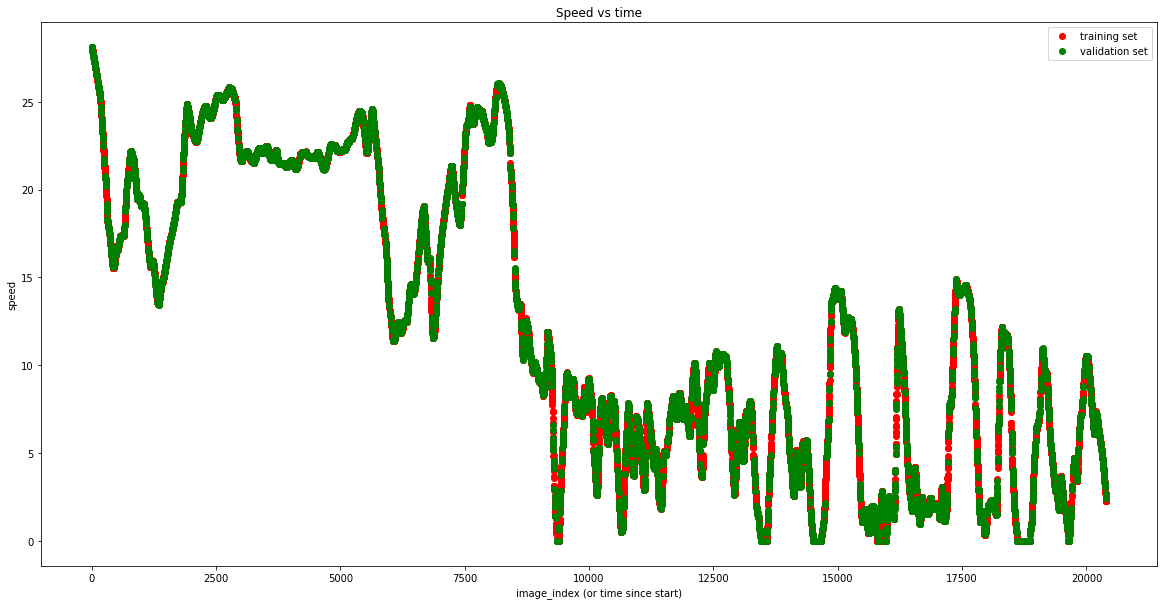

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [7]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [8]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [9]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

# Optic flow with lk dimensions 

In [10]:
def opticalFlow1D(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    output: mask
    """
    feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 5 )
    lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    image_current_saved = np.copy(image_current)
    image_next_saved = np.copy(image_next)
    
    image_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    image_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    p0 = cv2.goodFeaturesToTrack(image_current, mask = None, **feature_params)

    p1, st, err = cv2.calcOpticalFlowPyrLK(image_current, image_next, p0, None, **lk_params)


    color = np.random.randint(0, 255, (100, 3))

    mask = np.zeros_like(image_current)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel() # flatten
        c, d = old.ravel()
        mask = cv2.arrowedLine(mask, (a,b), (c, d), color[i].tolist(), 1, 8)
        
        image_next = cv2.circle(image_next_saved, (a, b), 1, color[i].tolist(), -1)
        image_next_fg = cv2.bitwise_and(image_next, image_next, mask = mask)
        
    dst = cv2.add(image_next, image_next_fg)
    return dst

In [11]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image



original image shape: (480, 640, 3)


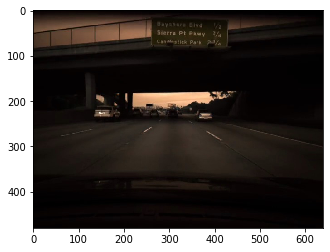

post prosessed image: (66, 220, 3)


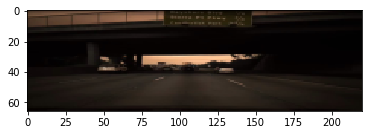

In [12]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [63]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlow1D(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlow1D(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [16]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [17]:
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [18]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

In [19]:
model = nvidia_model()

In [20]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size
)

print(history)

Epoch 1/15
400/400 [==============================] - 415s 1s/step - loss: 43.2078 - val_loss: 23.9195

Epoch 00001: val_loss improved from inf to 23.91951, saving model to model_assets/model=nvidia-batch_size=16-num_epoch=15-steps_per_epoch=400/weights.h5
Epoch 2/15
400/400 [==============================] - 433s 1s/step - loss: 19.3377 - val_loss: 9.5672

Epoch 00002: val_loss improved from 23.91951 to 9.56719, saving model to model_assets/model=nvidia-batch_size=16-num_epoch=15-steps_per_epoch=400/weights.h5
Epoch 3/15
400/400 [==============================] - 413s 1s/step - loss: 13.7716 - val_loss: 6.8605

Epoch 00003: val_loss improved from 9.56719 to 6.86045, saving model to model_assets/model=nvidia-batch_size=16-num_epoch=15-steps_per_epoch=400/weights.h5
Epoch 4/15
400/400 [==============================] - 413s 1s/step - loss: 10.0652 - val_loss: 4.9816

Epoch 00004: val_loss improved from 6.86045 to 4.98163, saving model to model_assets/model=nvidia-batch_size=16-num_epoch

In [21]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

# Post Analysis

In [22]:
# model processing hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' 
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

In [23]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [24]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 3.6493594438356847


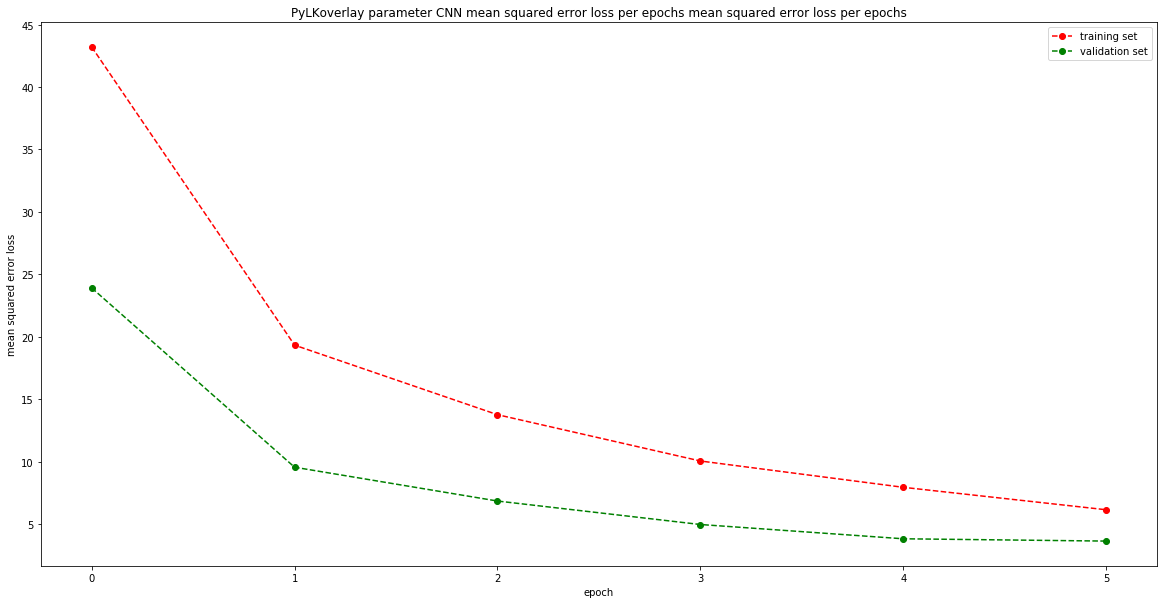

In [33]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('PyLKoverlay parameter CNN mean squared error loss per epochs mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [34]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlow1D(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [35]:
make_predictions(valid_data)

100%|██████████| 9030/9030 [05:25<00:00, 27.74it/s]


In [64]:
print(valid_data)


    index            image_path  image_index      speed  predicted_speed  \
0   19279  train_imgs/19279.jpg        19279   5.463822              NaN   
0   19280  train_imgs/19280.jpg        19280   5.465823         7.502538   
0     144    train_imgs/144.jpg          144  25.692820        20.370811   
0     145    train_imgs/145.jpg          145  25.694555        20.758261   
0   19433  train_imgs/19433.jpg        19433   1.979639         2.731458   
0   19434  train_imgs/19434.jpg        19434   1.945971         3.036988   
0   11742  train_imgs/11742.jpg        11742   7.163924         4.542729   
0   11743  train_imgs/11743.jpg        11743   7.192087         3.898876   
0    9529   train_imgs/9529.jpg         9529   8.916847         7.673730   
0    9530   train_imgs/9530.jpg         9530   8.951325         8.082198   
0   16277  train_imgs/16277.jpg        16277  11.417338        10.670323   
0   16278  train_imgs/16278.jpg        16278  11.418523        10.742854   
0   11032  t

In [66]:
print(test_meta)

             image_path  image_index     speed
0        val_imgs/0.jpg            0  2.022715
1        val_imgs/1.jpg            1  2.040872
2        val_imgs/2.jpg            2  2.062394
3        val_imgs/3.jpg            3  2.076283
4        val_imgs/4.jpg            4  2.077074
5        val_imgs/5.jpg            5  2.070870
6        val_imgs/6.jpg            6  2.107572
7        val_imgs/7.jpg            7  2.122324
8        val_imgs/8.jpg            8  2.127576
9        val_imgs/9.jpg            9  2.123339
10      val_imgs/10.jpg           10  2.133369
11      val_imgs/11.jpg           11  2.139515
12      val_imgs/12.jpg           12  2.130388
13      val_imgs/13.jpg           13  2.132890
14      val_imgs/14.jpg           14  2.137918
15      val_imgs/15.jpg           15  2.103168
16      val_imgs/16.jpg           16  2.077905
17      val_imgs/17.jpg           17  2.069317
18      val_imgs/18.jpg           18  2.055829
19      val_imgs/19.jpg           19  2.037641
20      val_i

In [36]:
print(mean_squared_error(valid_data.iloc[1:-1, 3], 
                         valid_data.iloc[1:-1, 4]))

3.6360461236026005


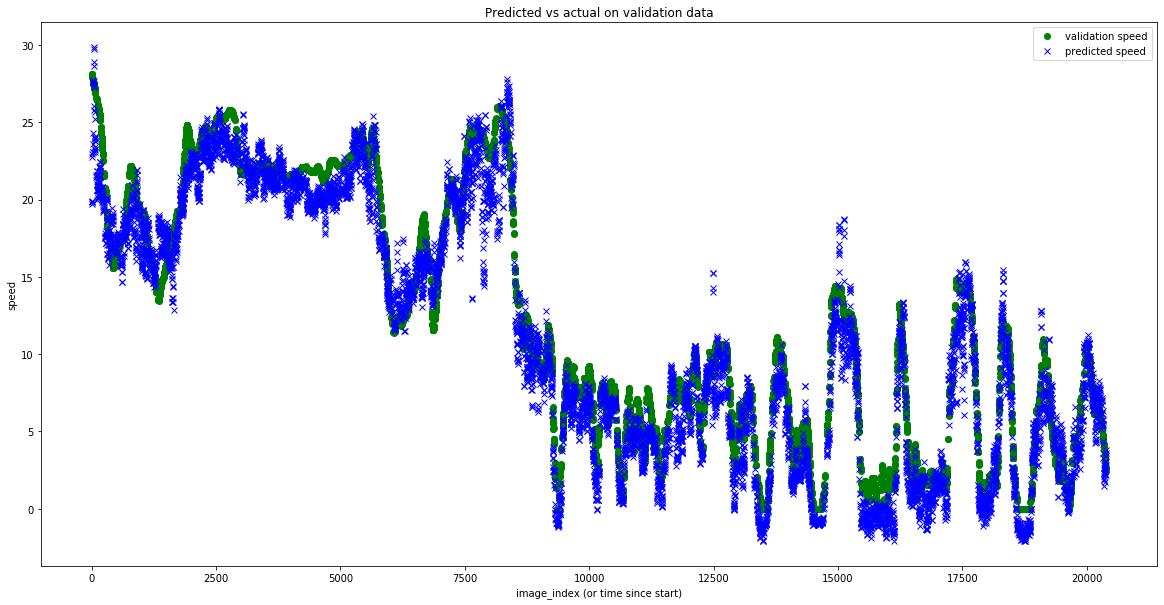

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

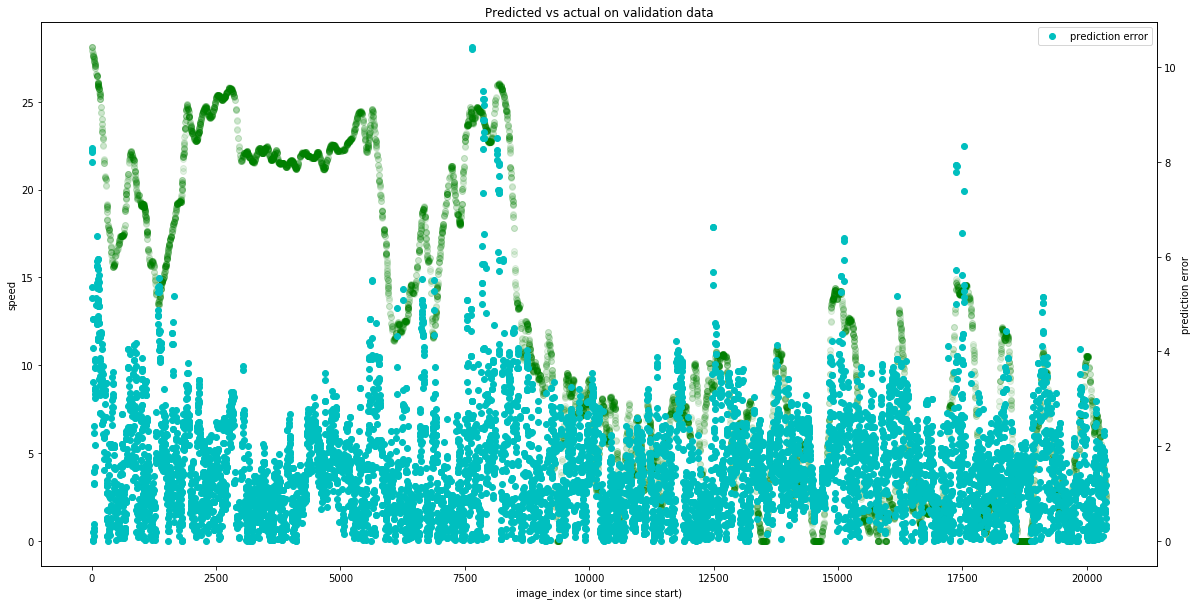

In [38]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [39]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
             valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

interactive(children=(FloatSlider(value=2.0, description='error_thresh', max=5.0), Output()), _dom_classes=('w…

<function __main__.error_analysis(error_thresh)>

## Predicting on Test

In [59]:
# constants

test_frames = 8616
CLEAN_DATA_PATH = ''
#CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')

test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test2_meta.csv'))
#assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

shape:  (8616, 3)


In [68]:
make_predictions(test_meta)

100%|██████████| 8614/8614 [04:55<00:00, 29.11it/s]


In [70]:
window_size = 25

test_meta['smooth_predicted_speed'] = test_meta['predicted_speed'].rolling(window = 25).mean()
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)
test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


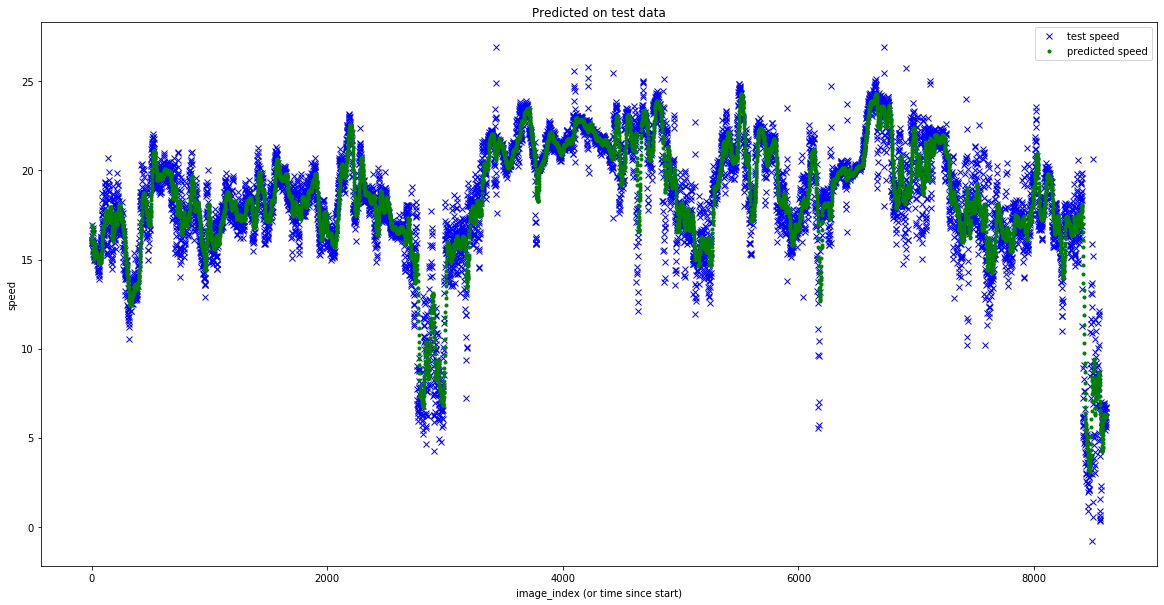

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(ASSETS_PATH, 'test.txt'), index=False)

In [ ]:
output_file.head()

# w/ gt

In [72]:
window_size = 25

test_meta['smooth_predicted_speed'] = test_meta['predicted_speed'].rolling(window = 25).mean()
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)
test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


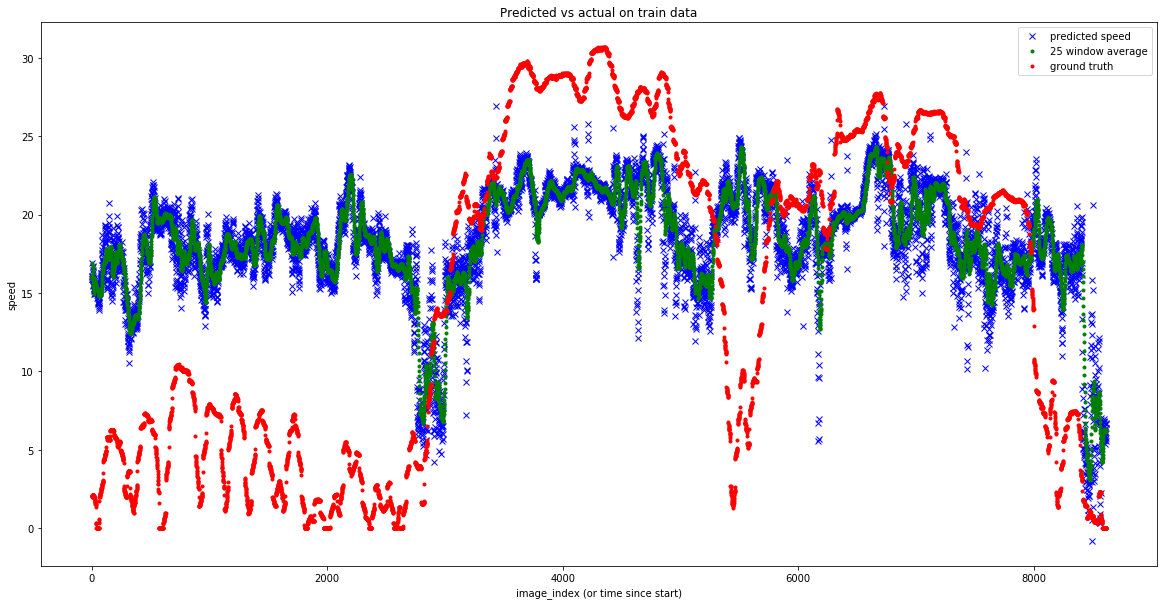

In [80]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on test data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [83]:
print(mean_squared_error(test_meta.iloc[1:-1, 3], 
                         test_meta.iloc[1:-1, 4]))

140.6116715472507


In [79]:
print(test_meta)

             image_path  image_index     speed  predicted_speed      error  \
0        val_imgs/0.jpg            0  2.022715              NaN        NaN   
1        val_imgs/1.jpg            1  2.040872        15.910951  13.870079   
2        val_imgs/2.jpg            2  2.062394        15.922097  13.859703   
3        val_imgs/3.jpg            3  2.076283        16.082029  14.005746   
4        val_imgs/4.jpg            4  2.077074        16.941086  14.864012   
5        val_imgs/5.jpg            5  2.070870        15.990657  13.919786   
6        val_imgs/6.jpg            6  2.107572        16.107746  14.000174   
7        val_imgs/7.jpg            7  2.122324        16.301809  14.179485   
8        val_imgs/8.jpg            8  2.127576        16.038094  13.910518   
9        val_imgs/9.jpg            9  2.123339        16.746462  14.623123   
10      val_imgs/10.jpg           10  2.133369        16.642357  14.508988   
11      val_imgs/11.jpg           11  2.139515        15.542266 